In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from utils.prepare_dataset import prepare_dataset_mnist

In [15]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_GPU = True if torch.cuda.is_available() else "cpu"

In [3]:
# max_seq_len = 64
# batch_size = 64
# dataset_size = 2000
# with_mask = False

# train_tokens, train_labels, train_mask, val_tokens, val_labels, val_mask = prepare_dataset_mnist(file="dataset/mnist_polygon_train_10k.csv",
#                                                                                                  with_mask=with_mask,
#                                                                                                  split_ratio=0.2,
#                                                                                                  dataset_size=dataset_size,
#                                                                                                  max_seq_len=max_seq_len,
#                                                                                                  train=True)

# test_tokens, test_labels, test_mask = prepare_dataset_mnist(file="dataset/mnist_polygon_test_2k.csv",
#                                                             with_mask=with_mask,
#                                                             max_seq_len=max_seq_len,
#                                                             dataset_size=500,
#                                                             train=False)

# train_loader = DataLoader(TensorDataset(train_tokens, train_labels), batch_size=batch_size, shuffle=True)

In [4]:
# import numpy as np

# batch_size = 64
# loaded = np.load("dataset/train_mnist_10k.npz")

# train_tokens, train_labels = loaded['train_tokens'][:2000], loaded['train_labels'][:2000]
# val_tokens, val_labels = loaded['train_tokens'][2000:2500], loaded['train_labels'][2000:2500]

# train_tokens = torch.tensor(train_tokens, dtype=torch.float32)
# val_tokens = torch.tensor(val_tokens, dtype=torch.float32)
# train_labels= torch.tensor(train_labels, dtype=torch.long)
# val_labels = torch.tensor(val_labels, dtype=torch.long)

# train_loader = DataLoader(TensorDataset(train_tokens, train_labels), batch_size=32, shuffle=True)
# val_loader = DataLoader(TensorDataset(val_tokens, val_labels), batch_size=32)

In [47]:
# import numpy as np
# from sklearn.model_selection import train_test_split

# batch_size = 64
# loaded = np.load("dataset/train_building_shape_5k.npz")

# split_ratio = 0.2
# train_tokens, val_tokens, train_labels, val_labels = train_test_split(loaded["train_tokens"], loaded["train_labels"], test_size=split_ratio, random_state=42)

# train_tokens = torch.tensor(train_tokens, dtype=torch.float32)
# val_tokens = torch.tensor(val_tokens, dtype=torch.float32)
# train_labels= torch.tensor(train_labels, dtype=torch.long)
# val_labels = torch.tensor(val_labels, dtype=torch.long)

# train_loader = DataLoader(TensorDataset(train_tokens, train_labels), batch_size=32, shuffle=True)
# val_loader = DataLoader(TensorDataset(val_tokens, val_labels), batch_size=32)

In [51]:
max_seq_len = 64
batch_size = 64
dataset_size = 2000
with_mask = False

train_tokens, train_labels, train_mask, val_tokens, val_labels, val_mask = prepare_dataset_mnist(file="dataset/building_shapes_5010.csv",
                                                                                                 with_mask=with_mask,
                                                                                                 split_ratio=0.2,
                                                                                                 dataset_size=dataset_size,
                                                                                                 max_seq_len=max_seq_len,
                                                                                                 train=True)

train_tokens = train_tokens[:, :, :2]
val_tokens = val_tokens[:, :, :2]

train_loader = DataLoader(TensorDataset(train_tokens, train_labels), batch_size=batch_size, shuffle=True)

In [ ]:
from utils.vector2shape import reverse_vector_polygon
i = 8
print(train_labels[i])
reverse_vector_polygon(train_tokens[i])

In [25]:
class ConvAE(nn.Module):
    def __init__(self, fea_dim):
        super().__init__()
        self.fea_dim = fea_dim
        self.encoder = nn.Sequential(nn.Conv1d(fea_dim, 16, kernel_size=3, padding=1, stride=2),
                                     nn.ReLU(),
                                     nn.Conv1d(16, 8, kernel_size=3, padding=1, stride=2),
                                     nn.ReLU(),
                                     nn.Conv1d(8, 4, kernel_size=3, padding=1, stride=1),)
        
        self.decoder = nn.Sequential(nn.ConvTranspose1d(4, 8, kernel_size=3, padding=1, stride=1, output_padding=0),
                                     nn.ReLU(),
                                     nn.ConvTranspose1d(8, 16, kernel_size=3, padding=1, stride=2, output_padding=1),
                                     nn.ReLU(),
                                     nn.ConvTranspose1d(16, fea_dim, kernel_size=3, padding=1, stride=2, output_padding=1))
        # self.relu = nn.ReLU()

        self.mse_loss_func = nn.MSELoss()
        self.meta_loss_func = nn.CrossEntropyLoss()
        
    def forward(self, x):

        permuated_x = x.permute(0, 2, 1)  # Permute to (batch_size, channels, seq_len)
        encoded = self.encoder(permuated_x)
        decoded = self.decoder(encoded)

        decoded = decoded.permute(0, 2, 1)

        coord_output = decoded[:, :, :self.fea_dim] # coord_output = decoded[:, :, :2]
        # meta_output1 = decoded[:, :, 2:4]
        # meta_output2 = decoded[:, :, 4:]
        # target_meta1 = torch.argmax(x[:, :, 2:4], dim=-1) # inner or outer points
        # target_meta2 = torch.argmax(x[:, :, 4:], dim=-1) # render one-hot code
        coord_loss = self.mse_loss_func(coord_output, x[:, :, :self.fea_dim]) # coord_loss = self.mse_loss_func(coord_output, x[:, :, :2])
        # # 2 is inner or outer one-hot vocab size, 3 is render one-hot vocab size
        # meta_loss1 = self.meta_loss_func(meta_output1.contiguous().view(-1, 2), target_meta1.contiguous().view(-1))
        # meta_loss2 = self.meta_loss_func(meta_output2.contiguous().view(-1, 3), target_meta2.contiguous().view(-1))

        # meta_indices1 = torch.argmax(meta_output1, dim=-1)
        # meta_indices2 = torch.argmax(meta_output2, dim=-1)
        # output = torch.cat([coord_output, nn.functional.one_hot(meta_indices1, 2), nn.functional.one_hot(meta_indices2, 3)], dim=-1)
        output = coord_output

        # return encoded, output, coord_loss*0.25 + (meta_loss1 + meta_loss2)*0.75
        return encoded, output, coord_loss

In [52]:
fea_dim = 2
cae = ConvAE(fea_dim)
optimizer = optim.Adam(cae.parameters(), lr=0.004)

num_epoch = 50

for epoch in range(num_epoch):
    cae.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        hidden, outputs, loss = cae(inputs)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    train_loss = total_loss/len(train_loader)

    cae.eval()
    with torch.no_grad():
        val_hidden, val_outputs, loss = cae(train_tokens)
        val_loss = loss.item()
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

Epoch 1, Train Loss: 0.2579280334711075, Val Loss: 0.19278688728809357
Epoch 2, Train Loss: 0.14380424469709396, Val Loss: 0.10328639298677444
Epoch 3, Train Loss: 0.07216765001416206, Val Loss: 0.04131088778376579
Epoch 4, Train Loss: 0.030563021078705788, Val Loss: 0.022603316232562065
Epoch 5, Train Loss: 0.01828874580562115, Val Loss: 0.014204963110387325
Epoch 6, Train Loss: 0.011646437495946883, Val Loss: 0.00924586784094572
Epoch 7, Train Loss: 0.007820464987307787, Val Loss: 0.006680099293589592
Epoch 8, Train Loss: 0.005890242289751768, Val Loss: 0.005203524604439735
Epoch 9, Train Loss: 0.004757679458707571, Val Loss: 0.004277460742741823
Epoch 10, Train Loss: 0.003967858282849192, Val Loss: 0.003649009158834815
Epoch 11, Train Loss: 0.003433679919689894, Val Loss: 0.0032195833045989275
Epoch 12, Train Loss: 0.0030222449637949465, Val Loss: 0.0029319394379854202
Epoch 13, Train Loss: 0.002803136669099331, Val Loss: 0.0026515452191233635
Epoch 14, Train Loss: 0.002547638723626

In [ ]:
from utils.vector2shape import reverse_vector_polygon
import matplotlib.pyplot as plt

show_tokens = val_tokens[:10]

cae.eval()
with torch.no_grad():
    show_hidden, show_outputs, _ = cae(show_tokens)

num_samples = 10
ori_polygons = [reverse_vector_polygon(token) for token in show_tokens]
new_polygons = [reverse_vector_polygon(token) for token in show_outputs]

# Create a figure with subplots for each polygon
fig, axs = plt.subplots(2, num_samples, figsize=(5*num_samples, 10))

# Plot polygons from the first list
for i, polygon in enumerate(ori_polygons):
    axs[0, i].set_title('Polygon {} from List 1'.format(i+1))
    x, y = polygon.exterior.xy
    axs[0, i].plot(x, y)
    holes_x = [[coord[0] for coord in interior.coords] for interior in polygon.interiors]
    holes_y = [[coord[1] for coord in interior.coords] for interior in polygon.interiors]
    if holes_x:
        for hole_x, hole_y in zip(holes_x, holes_y):
            axs[0, i].plot(hole_x, hole_y)

# Plot polygons from the second list
for i, polygon in enumerate(new_polygons):
    axs[1, i].set_title('Polygon {} from List 2'.format(i+1))
    x, y = polygon.exterior.xy
    axs[1, i].plot(x, y)
    holes_x = [[coord[0] for coord in interior.coords] for interior in polygon.interiors]
    holes_y = [[coord[1] for coord in interior.coords] for interior in polygon.interiors]
    if holes_x:
        for hole_x, hole_y in zip(holes_x, holes_y):
            axs[1, i].plot(hole_x, hole_y)

# Show the plot
plt.show()

In [53]:
from utils.embeding_evaluate import compute_NN, compute_FT, compute_ST

show_hidden = val_hidden.reshape(val_hidden.size(0), -1)
show_labels = train_labels

"Embedding", compute_NN(show_hidden, show_labels), compute_FT(show_hidden, show_labels), compute_ST(show_hidden, show_labels)

('Embedding', 0.8125, 0.19389827856736866, 0.29746808657533186)

In [54]:
show_hidden = train_tokens.reshape(train_tokens.size(0), -1)
show_labels = train_labels

"Original", compute_NN(show_hidden, show_labels), compute_FT(show_hidden, show_labels), compute_ST(show_hidden, show_labels)

('Original', 0.80875, 0.1946533983245083, 0.2957395614116295)

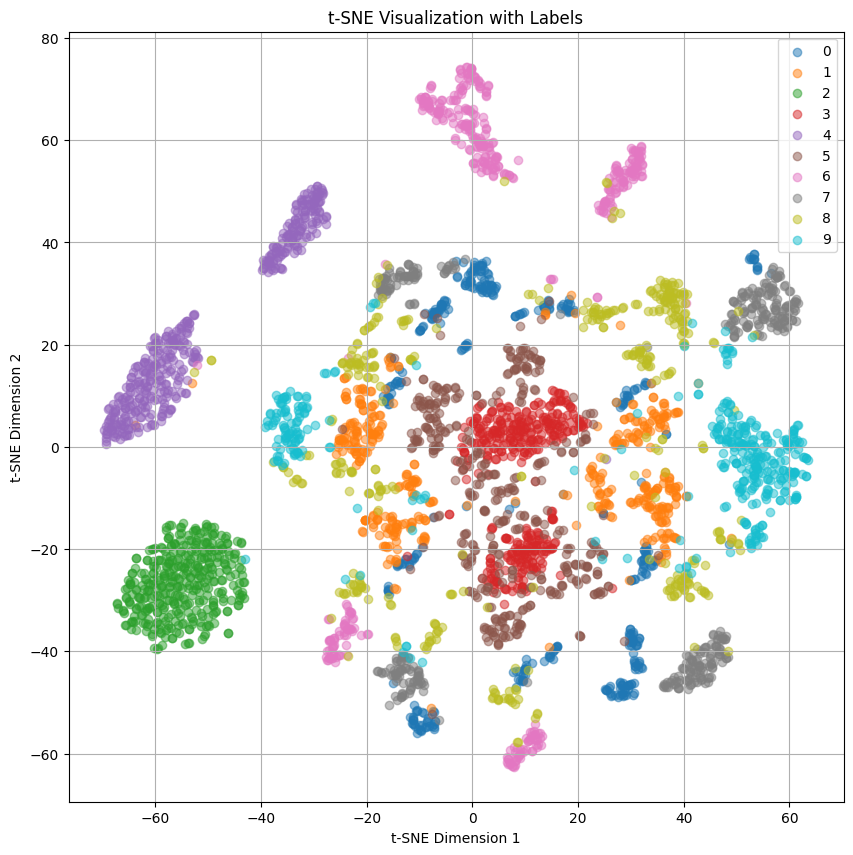

In [30]:
# show_hidden = val_hidden.reshape(val_hidden.size(0), -1)
# show_labels = train_labels

show_hidden = train_tokens.reshape(train_tokens.size(0), -1)
show_labels = train_labels

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np


tsne = TSNE(n_components=2, init='pca', random_state=0)
projections = tsne.fit_transform(show_hidden)

plt.figure(figsize=(10, 10))

# Plot each class separately
for label in np.unique(show_labels):
    indices = show_labels == label
    plt.scatter(projections[indices, 0], projections[indices, 1], label=label, alpha=0.5)

plt.title('t-SNE Visualization with Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
cae.eval()
with torch.no_grad():
    cls_train_hidden = cae(train_tokens)[0].view(train_tokens.size(0), -1)
    cls_val_hidden = cae(val_tokens)[0].view(val_tokens.size(0), -1)


    # tsne = PCA(n_components=64, random_state=0)
    # train_hidden = torch.tensor(tsne.fit_transform(train_hidden), dtype=torch.float32)
    # val_hidden = torch.tensor(tsne.transform(val_hidden), dtype=torch.float32)

# # Without encoding
# cls_train_hidden = train_tokens.reshape(train_tokens.size(0), -1)
# cls_val_hidden = val_tokens.reshape(val_tokens.size(0), -1)

cls_train_loader = DataLoader(TensorDataset(cls_train_hidden, train_labels), batch_size=batch_size, shuffle=True)

In [60]:
# Define the classifier
class Classifier(nn.Module):
    def __init__(self, input_size, dense_size, num_classes, dropout):
        super().__init__()
        self.dense1 = nn.Linear(input_size, dense_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_size, num_classes)

    def forward(self, x):
        x = self.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        # # Linear probing
        # x = self.dense1(x)

        return x
    
classifier = Classifier(cls_train_hidden.size(1), 128, 10, 0.0)

if USE_GPU:
    classifier = classifier.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.004)
# optimizer = optim.Adam(classifier.parameters(), lr=0.004, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001)

num_epochs = 100

def train(model, loader):
    model.eval()
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_x, batch_y in loader:
        if USE_GPU:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, dim=-1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    train_loss /= len(loader)
    train_acc = correct / total
    return train_loss, train_acc

def evaluate(model, tokens, labels):
    model.eval()
    with torch.no_grad():
        if USE_GPU:
            tokens, labels = tokens.to(device), labels.to(device)
        outputs = model(tokens)
        eval_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, dim=-1)
        eval_acc = (predicted == labels).sum().item() / labels.size(0)
    return eval_loss, eval_acc

for epoch in range(num_epochs):
    train_loss, train_acc = train(classifier, cls_train_loader)
    val_loss, val_acc = evaluate(classifier, cls_val_hidden, val_labels)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss}, Train Acc {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}")


# # Test
# test_loss, test_acc = evaluate(classifier, test_loader)
# print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

Epoch: 1, Train Loss: 1.7664232444763184, Train Acc 0.381875, Val Loss: 1.6521728038787842, Val Acc: 0.4675
Epoch: 2, Train Loss: 1.4733700704574586, Train Acc 0.52875, Val Loss: 1.4912099838256836, Val Acc: 0.5575
Epoch: 3, Train Loss: 1.2079882168769835, Train Acc 0.6125, Val Loss: 1.2707016468048096, Val Acc: 0.64
Epoch: 4, Train Loss: 1.0357740235328674, Train Acc 0.675, Val Loss: 1.184126377105713, Val Acc: 0.655
Epoch: 5, Train Loss: 0.9190769743919373, Train Acc 0.700625, Val Loss: 1.018527865409851, Val Acc: 0.6975
Epoch: 6, Train Loss: 0.7966291213035583, Train Acc 0.744375, Val Loss: 0.9758186340332031, Val Acc: 0.715
Epoch: 7, Train Loss: 0.7247467446327209, Train Acc 0.75875, Val Loss: 0.9700247049331665, Val Acc: 0.715
Epoch: 8, Train Loss: 0.6763390398025513, Train Acc 0.786875, Val Loss: 0.8440402746200562, Val Acc: 0.75
Epoch: 9, Train Loss: 0.600357574224472, Train Acc 0.806875, Val Loss: 0.8117127418518066, Val Acc: 0.75
Epoch: 10, Train Loss: 0.5595082437992096, Trai

In [208]:
labels_array = val_labels.numpy()
length = labels_array.shape[0]
# Find unique classes and their frequencies
unique_classes, class_counts = np.unique(labels_array, return_counts=True)
fre_dict = {c: count/length for c, count in zip(unique_classes, class_counts)}
fre_dict

{0: 0.114,
 1: 0.1,
 2: 0.11,
 3: 0.086,
 4: 0.104,
 5: 0.082,
 6: 0.118,
 7: 0.11,
 8: 0.082,
 9: 0.094}